# Travelling Salesman Problem (TSP) via Fast Simulated Annealing (FSA)

## Quick introduction to FSA

* $T_0 \in \mathbb{R}$ initial temperature
* $ n_0 \in \mathbb{N} $ and $ \alpha \in \mathbb{R}$ — cooling strategy parameters
* $k$-th step:
  * Evaluate current temperature:
    * $ T = \frac{T_0}{1+(k/n_0)^\alpha} $ for $ \alpha > 0 $,
    * $ T = T_0 \cdot \exp(-(k/n_0)^{-\alpha}) $ otherwise.
  * **Mutate** the solution `x` -> `y`
  * $s = \frac{f_x-f_y}{T}$
  * replace `x` with `y` if $u < 1/2 + \arctan(s)/\pi$ where $u$ is random (uniform) number
  
Cauchy **mutation operator**:

* mutation perimeter (width) controlled by parameter $r \in \mathbb{R}$
* $ \mathbf{x}_\mathrm{new} = \mathbf{x} + r \cdot \tan{\left(\pi \left(\mathbf{r} - \dfrac{1}{2}\right)\right)} $ where $\mathbf{r}$ is random uniform vector


In [1]:
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..', 'src')))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
%load_ext autoreload
%autoreload 2

In [2]:
# Import external libraries
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Initialize `TSPGrid(3, 3)`

In [3]:
# initialization
from objfun_tsp import TSPGrid
tsp = TSPGrid(3, 3)

## Referential performance: Random Shooting ($\mathrm{SG}_{0}$) and Steepest Descent ($\mathrm{SG}_{\infty}$)

In [ ]:
from heur_sg import ShootAndGo

In [4]:
NUM_RUNS = 1000 # set to something lower for quick own experiments
maxeval = 1000

In [5]:
def experiment_sg(of, maxeval, num_runs, hmax):
    results = []
    for i in tqdm(range(num_runs), 'Testing hmax={}'.format(hmax)):
        result = ShootAndGo(of, maxeval=maxeval, hmax=hmax).search() # dict with results of one run
        result['run'] = i
        result['heur'] = 'SG_{}'.format(hmax) # name of the heuristic
        result['hmax'] = hmax
        results.append(result)
    
    return pd.DataFrame(results, columns=['heur', 'run', 'hmax', 'best_x', 'best_y', 'neval'])

In [6]:
table_ref = pd.DataFrame()

for hmax in [0, np.inf]:
    res = experiment_sg(of=tsp, maxeval=maxeval, num_runs=NUM_RUNS, hmax=hmax)
    table_ref = pd.concat([table_ref, res], axis=0)

In [7]:
table_ref.head()

,heur,run,hmax,best_x,best_y,neval
0,SG_0,0,0.0,"[0, 0, 2, 4, 2, 2, 1, 0]",10.000000,inf
1,SG_0,1,0.0,"[2, 4, 4, 3, 3, 2, 1, 0]",10.242641,inf
2,SG_0,2,0.0,"[0, 0, 2, 4, 2, 2, 1, 0]",10.000000,inf
3,SG_0,3,0.0,"[0, 0, 2, 4, 3, 1, 1, 0]",9.414214,869.000000
4,SG_0,4,0.0,"[3, 0, 0, 1, 3, 2, 1, 0]",9.414214,197.000000


In [8]:
# from the last class...

def rel(x):
    return len([n for n in x if n < np.inf])/len(x)

def mne(x):
    return np.mean([n for n in x if n < np.inf])

def feo(x):
    return mne(x)/rel(x)

In [9]:
stats_ref = table_ref.pivot_table(
    index=['heur'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
stats_ref = stats_ref.reset_index()

In [10]:
stats_ref

,heur,feo,mne,rel
0,SG_0,1423.527197,475.458084,0.334
1,SG_inf,372.381901,335.516093,0.901


## TSP optimization using FSA

Please, inspect the new code first!

In [11]:
from heur_fsa import FastSimulatedAnnealing
from heur_aux import Correction, CauchyMutation

Let's evaluate performance of different temperatures...

In [12]:
def experiment_fsa(of, maxeval, num_runs, T0, n0, alpha, r):
    results = []
    for i in tqdm(range(num_runs), 'Testing T0={}, n0={}, alpha={}, r={}'.format(T0, n0, alpha, r)):
        mut = CauchyMutation(r=r, correction=Correction(of))
        result = FastSimulatedAnnealing(of, maxeval=maxeval, T0=T0, n0=n0, alpha=alpha, mutation=mut).search()
        result['run'] = i
        result['heur'] = 'FSA_{}_{}_{}_{}'.format(T0, n0, alpha, r) # name of the heuristic
        result['T0'] = T0
        result['n0'] = n0
        result['alpha'] = alpha
        result['r'] = r
        results.append(result)
    
    return pd.DataFrame(results, columns=['heur', 'run', 'T0', 'n0', 'alpha', 'r', 'best_x', 'best_y', 'neval'])

In [13]:
table_fsa = pd.DataFrame()

for T0 in [1e-10, 1e-2, 1, np.inf]:
    res = experiment_fsa(of=tsp, maxeval=maxeval, num_runs=NUM_RUNS, T0=T0, n0=1, alpha=2, r=0.5)
    table_fsa = pd.concat([table_fsa, res], axis=0)

In [14]:
stats_fsa = table_fsa.pivot_table(
    index=['heur', 'T0'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
stats_fsa = stats_fsa.reset_index()
stats_fsa.sort_values(by=['T0'])

,heur,T0,feo,mne,rel
2,FSA_1e-10_1_2_0.5,1.000000e-10,334.019188,248.844295,0.745
0,FSA_0.01_1_2_0.5,1.000000e-02,339.516329,254.297730,0.749
1,FSA_1_1_2_0.5,1.000000e+00,329.784131,245.029610,0.743
3,FSA_inf_1_2_0.5,inf,1129.265186,460.740196,0.408


# Analysis

**Can we improve the best configuration ($T_0=1$)?**

Let's carefully analyze the data...

In [16]:
heur = FastSimulatedAnnealing(tsp, maxeval=1000, T0=1, n0=1, alpha=2, 
                              mutation=CauchyMutation(r=0.5, correction=Correction(tsp)))
result = heur.search()
print('neval = {}'.format(result['neval']))
print('best_x = {}'.format(result['best_x']))
print('best_y = {}'.format(result['best_y']))

neval = 255
best_x = [3 2 3 3 3 2 1 0]
best_y = 9.414213562373096


In [17]:
log_data = result['log_data'].copy()
log_data = log_data[['step', 'x', 'f_x', 'y', 'f_y', 'T', 'swap']]  # column re-ordering, for better readability
log_data.head(10)

,step,x,f_x,y,f_y,T,swap
0,0,"[1, 3, 3, 1, 2, 1, 0, 0]",14.714777,"[1, 0, 3, 1, 3, 2, 1, 0]",13.478709,1.000000,False
1,1,"[1, 3, 3, 1, 2, 1, 0, 0]",14.714777,"[3, 3, 3, 1, 2, 0, 0, 0]",18.193485,0.500000,True
2,2,"[3, 3, 3, 1, 2, 0, 0, 0]",18.193485,"[0, 3, 3, 0, 2, 0, 0, 0]",16.371631,0.200000,True
3,3,"[0, 3, 3, 0, 2, 0, 0, 0]",16.371631,"[0, 2, 5, 0, 2, 0, 0, 0]",14.892922,0.100000,True
4,4,"[0, 2, 5, 0, 2, 0, 0, 0]",14.892922,"[0, 3, 5, 0, 1, 1, 0, 0]",12.892922,0.058824,True
5,5,"[0, 3, 5, 0, 1, 1, 0, 0]",12.892922,"[1, 3, 5, 0, 3, 2, 0, 0]",12.650282,0.038462,True
6,6,"[1, 3, 5, 0, 3, 2, 0, 0]",12.650282,"[5, 4, 4, 0, 3, 2, 0, 0]",15.950845,0.027027,False
7,7,"[1, 3, 5, 0, 3, 2, 0, 0]",12.650282,"[7, 3, 5, 1, 2, 0, 0, 0]",14.307136,0.020000,False
8,8,"[1, 3, 5, 0, 3, 2, 0, 0]",12.650282,"[2, 4, 5, 0, 1, 1, 0, 0]",13.708204,0.015385,False
9,9,"[1, 3, 5, 0, 3, 2, 0, 0]",12.650282,"[0, 4, 2, 0, 3, 2, 0, 0]",14.714777,0.012195,False


In [18]:
def plot_compare(step_data, ax1_col, ax1_label, ax2_col, ax2_label):
    fig, ax1 = plt.subplots()

    k = step_data.index.values
    T = step_data[ax1_col]
    ax1.plot(k, T, 'b-')
    ax1.set_xlabel('Step')
    ax1.set_ylabel(ax1_label, color='b')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')

    ax2 = ax1.twinx()
    s2 = step_data[ax2_col]
    ax2.plot(k, s2, 'r.')
    ax2.set_ylabel(ax2_label, color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')

    plt.show()

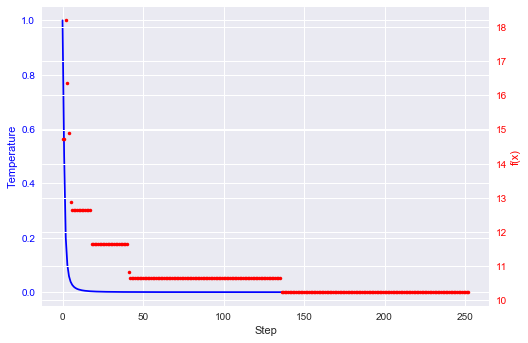

In [19]:
plot_compare(log_data, 'T', 'Temperature', 'f_x', 'f(x)')

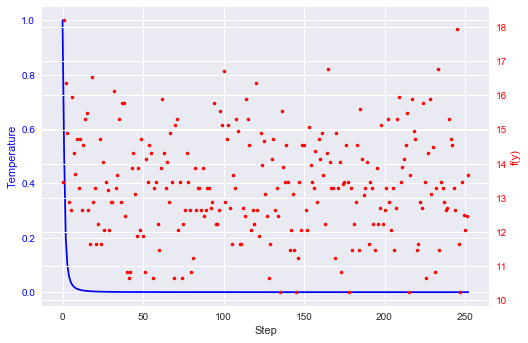

In [20]:
plot_compare(log_data, 'T', 'Temperature', 'f_y', 'f(y)')

### Slower cooling?

Let's double $n_0$:

In [27]:
heur = FastSimulatedAnnealing(tsp, maxeval=1000, T0=1, n0=2, alpha=2, 
                              mutation=CauchyMutation(r=0.5, correction=Correction(tsp)))
result = heur.search()
print('neval = {}'.format(result['neval']))
print('best_x = {}'.format(result['best_x']))
print('best_y = {}'.format(result['best_y']))

neval = 64
best_x = [0 2 0 1 3 2 1 0]
best_y = 9.414213562373096


In [28]:
log_data = result['log_data'].copy()
log_data = log_data[['step', 'x', 'f_x', 'y', 'f_y', 'T', 'swap']]  # column re-ordering, for better readability

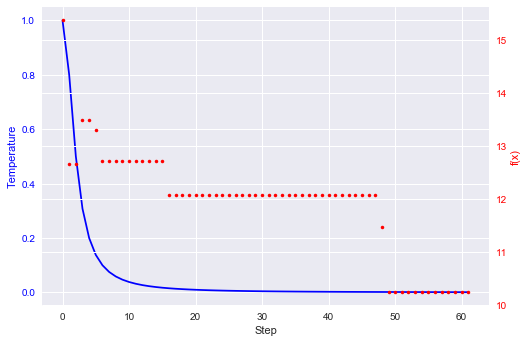

In [29]:
plot_compare(log_data, 'T', 'Temperature', 'f_x', 'f(x)')

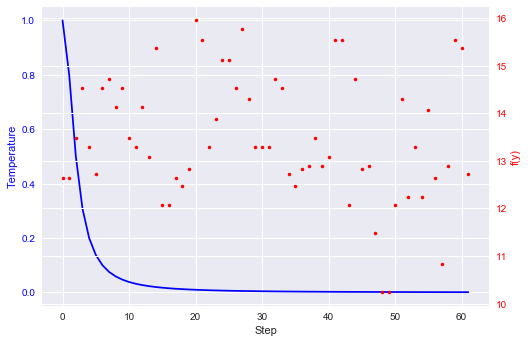

In [30]:
plot_compare(log_data, 'T', 'Temperature', 'f_y', 'f(y)')

**More thorough testing**:

In [31]:
for n0 in [2, 3, 5, 10]:
    res = experiment_fsa(of=tsp, maxeval=maxeval, num_runs=NUM_RUNS, T0=1, n0=n0, alpha=2, r=0.5)
    table_fsa = pd.concat([table_fsa, res], axis=0)

In [32]:
stats_fsa = table_fsa.pivot_table(
    index=['heur', 'T0', 'n0'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
stats_fsa = stats_fsa.reset_index()
stats_fsa.sort_values(by=['T0', 'n0'])

,heur,T0,n0,feo,mne,rel
6,FSA_1e-10_1_2_0.5,1.000000e-10,1,334.019188,248.844295,0.745
0,FSA_0.01_1_2_0.5,1.000000e-02,1,339.516329,254.297730,0.749
2,FSA_1_1_2_0.5,1.000000e+00,1,329.784131,245.029610,0.743
3,FSA_1_2_2_0.5,1.000000e+00,2,320.524444,240.393333,0.750
4,FSA_1_3_2_0.5,1.000000e+00,3,336.088847,249.041835,0.741
5,FSA_1_5_2_0.5,1.000000e+00,5,310.057024,240.294194,0.775
1,FSA_1_10_2_0.5,1.000000e+00,10,310.668429,240.457364,0.774
7,FSA_inf_1_2_0.5,inf,1,1129.265186,460.740196,0.408


### Is the mutation $r$ adequate?

In [33]:
log_data['jump_length'] = log_data.apply(lambda r: np.linalg.norm(r['x'] - r['y']), axis=1)
log_data.head(10)

,step,x,f_x,y,f_y,T,swap,jump_length
0,0,"[2, 2, 1, 2, 0, 2, 1, 0]",15.365058,"[2, 2, 0, 2, 3, 2, 1, 0]",12.650282,1.000000,True,3.162278
1,1,"[2, 2, 0, 2, 3, 2, 1, 0]",12.650282,"[2, 2, 0, 2, 3, 2, 1, 0]",12.650282,0.800000,True,0.000000
2,2,"[2, 2, 0, 2, 3, 2, 1, 0]",12.650282,"[2, 2, 0, 1, 3, 2, 0, 0]",13.478709,0.500000,True,1.414214
3,3,"[2, 2, 0, 1, 3, 2, 0, 0]",13.478709,"[0, 2, 0, 0, 3, 2, 0, 0]",14.536631,0.307692,False,2.236068
4,4,"[2, 2, 0, 1, 3, 2, 0, 0]",13.478709,"[3, 2, 0, 0, 3, 2, 1, 0]",13.300563,0.200000,True,1.732051
5,5,"[3, 2, 0, 0, 3, 2, 1, 0]",13.300563,"[4, 1, 0, 0, 3, 2, 1, 0]",12.714777,0.137931,True,1.414214
6,6,"[4, 1, 0, 0, 3, 2, 1, 0]",12.714777,"[3, 2, 0, 0, 2, 2, 1, 0]",14.536631,0.100000,False,1.732051
7,7,"[4, 1, 0, 0, 3, 2, 1, 0]",12.714777,"[4, 0, 1, 0, 3, 1, 1, 0]",14.714777,0.075472,False,1.732051
8,8,"[4, 1, 0, 0, 3, 2, 1, 0]",12.714777,"[3, 1, 0, 0, 3, 2, 0, 0]",14.128990,0.058824,False,1.414214
9,9,"[4, 1, 0, 0, 3, 2, 1, 0]",12.714777,"[4, 0, 0, 0, 3, 2, 0, 0]",14.536631,0.047059,False,1.414214


In [34]:
log_data['jump_length'].describe()

count    62.000000
mean      2.407013
std       1.341579
min       0.000000
25%       1.414214
50%       2.236068
75%       3.316625
max       5.744563
Name: jump_length, dtype: float64

In [35]:
for r in [.1, .25, .75, 1, 2]:
    res = experiment_fsa(of=tsp, maxeval=maxeval, num_runs=NUM_RUNS, T0=1, n0=5, alpha=2, r=r)
    table_fsa = pd.concat([table_fsa, res], axis=0)

In [36]:
stats_fsa = table_fsa.pivot_table(
    index=['heur', 'T0', 'n0', 'r'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
stats_fsa = stats_fsa.reset_index()
stats_fsa.sort_values(by=['T0', 'n0', 'r'])

,heur,T0,n0,r,feo,mne,rel
11,FSA_1e-10_1_2_0.5,1.000000e-10,1,0.50,334.019188,248.844295,0.745
0,FSA_0.01_1_2_0.5,1.000000e-02,1,0.50,339.516329,254.297730,0.749
2,FSA_1_1_2_0.5,1.000000e+00,1,0.50,329.784131,245.029610,0.743
3,FSA_1_2_2_0.5,1.000000e+00,2,0.50,320.524444,240.393333,0.750
4,FSA_1_3_2_0.5,1.000000e+00,3,0.50,336.088847,249.041835,0.741
5,FSA_1_5_2_0.1,1.000000e+00,5,0.10,662.166203,278.771971,0.421
6,FSA_1_5_2_0.25,1.000000e+00,5,0.25,394.383064,237.418605,0.602
7,FSA_1_5_2_0.5,1.000000e+00,5,0.50,310.057024,240.294194,0.775
8,FSA_1_5_2_0.75,1.000000e+00,5,0.75,307.680097,252.605359,0.821
9,FSA_1_5_2_1,1.000000e+00,5,1.00,317.563514,275.327566,0.867


The best performing instance of FSA, according to $FEO$:

In [37]:
stats_fsa.sort_values(by=['feo']).head(1)

,heur,T0,n0,r,feo,mne,rel
8,FSA_1_5_2_0.75,1.0,5,0.75,307.680097,252.605359,0.821


## Conclusion

When assessing heuristic performance, always try to combine _prior_ knowledge with _posterior_ data collected during experimental phase. On the other hand, exhaustive grid parameter space search can be useful as well, but you will learn much more using this iterative approach.

## Assignment

1. Could you further improve performance of FSA on this instance of TSP? E.g. try to figure out and test other mutation correction strategies.
2. We have performed analyses of the `log_data` contents on a single run of a heuristic. Try to aggregate and make use of these statistics on multiple experimental runs.
3. When FSA search is successful, the last objective function call is missing in the `log_data` output variable. Could you improve this behaviour?

Publish your solution as a [pull request](https://help.github.com/articles/about-pull-requests/), ideally.